In [1]:
# Volume Flux
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gsw
import Functions as fun
import os, sys

In [2]:
def VolFlux(datapath, case_id, xid):
    # Calculate along-fjord volume fluxes at cross-section xid
    State0 = xr.open_dataset(datapath+'state_' + str(format(case_id,'03d')) + '.nc')
    State = State0.isel(T=~State0.get_index("T").duplicated())
    Grid = xr.open_dataset(datapath+'grid.nc')

    state = State.isel(X=slice(200), Xp1=slice(201), Y=slice(35,45))
    grid = Grid.isel(X=slice(200), Xp1=slice(201), Y=slice(35,45))  
    
    time = state.T.data / 86400

    area = grid.drF * grid.dyF * grid.HFacC
    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2
    Qp = np.empty(len(time))
    Ql = np.empty(len(time))
    for t in range(len(time)):
        Q = U[t,:,:,xid] * area.data[:,:,xid]
        Qp[t] = Q[Q > 0].sum()
        # last_positive_id = np.where(Q.mean(1) > 0)[0][-1]
        # Ql[t] = Q[last_positive_id:,:].sum()
    
        # Find the index of the last positive value in each column using a masked array
        masked_positives = np.ma.masked_array(Q, mask=Q <= 0)
        last_positive_indices = np.ma.argmax(masked_positives, axis=0)

        # Initialize a total sum of lower-layer negatives
        total_sum_lower_negatives = 0

        # Calculate the sum for each column based on the last positive index
        for col in range(Q.shape[1]):
        # Adjust for columns where the maximum index is 0 but it's actually a negative value
            if Q[0, col] > 0 or np.max(masked_positives[:, col]) > 0:
                index = last_positive_indices[col] + 1
            else:
                index = 0  # If no positive values, start from the beginning
            Ql[t] += np.sum(Q[index:, col][Q[index:, col] < 0])
    
    return time, Qp, Ql

In [8]:
path1 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_Wind1_S/' # Single wind event with sill
path2 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_Wind1_NS/' # Single wind event without sill
path3 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_Wind30_S/' # Persistent Wind for 30d
taum1 = np.array([0, 0.1, 0.3, -0.1, -0.3, 0.9, 1.5, -0.9, -1.5]) # Maximum zonal wind stress
taum3 = [0.1, 0.3, 0.9, 1.5, -0.1, -0.3, -0.9, -1.5]
xsill = 95
Qls = [] # lower layer volume flux with sill
Ql = [] # lower layer volume flux without sill

caseid = [9,8,5,4,1,2,3,6,7]

for i in np.argsort(taum3)+1:
    time, Qp1, Ql1 = VolFlux(path3,i,xsill)
    #time, Qp2, Ql2 = VolFlux(path2,i,xsill) 
    #Qls.append(Ql1[:13].mean())
    Qls.append(Ql1[-21:].mean())
    #Ql.append(Ql2[:13].mean())

In [14]:
np.argsort(taum3)

array([7, 6, 5, 4, 0, 1, 2, 3])

In [9]:
Qls, Qls[5]/Qls[4]

([-3877.070288580879,
  -4217.865772753391,
  -1602.1225149448323,
  -3887.95420403604,
  -5934.601512392184,
  -7947.763257692385,
  -7827.445437939356,
  -8048.806786372448],
 1.3392244182017057)

In [15]:
#taum = np.array([0, 0.1, 0.3, -0.1, -0.3, 0.9, 1.5, -0.9, -1.5])
Tau = [-1.5, -0.9, -0.3, -0.1, 0, 0.1, 0.3, 0.9, 1.5]
Tau = [-1.5, -0.9, -0.3, -0.1, 0.1, 0.3, 0.9, 1.5]
lr = np.polyfit(Tau,Qls, 1) # Linear regression
Tau_lr = np.linspace(-1.1,1.4,50)
Q_lr = lr[0]*Tau_lr+lr[1]

corr_matrix = np.corrcoef(Qls, lr[0]*np.array(Tau)+lr[1])
corr = corr_matrix[0,1]
R_sq = corr**2
print(R_sq)

0.5321555937498434


Text(0.5, 0, 'Down-fjord Wind Stress [$N\\,m^{-2}$]')

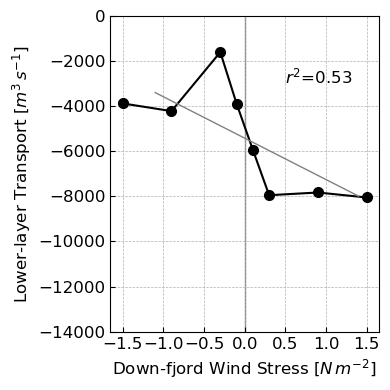

In [16]:
fig0 = plt.figure(figsize=(4,4),tight_layout=True)
#fig0.tight_layout()
X = [-1.5, -0.9, -0.3, -0.1, 0.1, 0.3, 0.9, 1.5]
ax1 = fig0.add_subplot(111)
plt.grid(linestyle = '--', linewidth = 0.5)

#ax1.plot(X,Ql,'s-',c='gray',ms=8,label=r'No Sill')
ax1.plot(X,Qls,'o-',c='k',lw=1.5,ms=7,label=r'With Sill')
ax1.axvline(x=0, color='grey',ls='-',lw=1,zorder=1)
ax1.plot(Tau_lr,Q_lr,'-',c='grey',lw=1,label=r'Linear Reg')
ax1.text(0.5,-3000,f'$r^2$={R_sq:.2f}', fontsize=12)
#ax1.legend(loc='best', fontsize=12)
ax1.tick_params(direction='in', labelsize=12)
ax1.set_ylim([-14000,0])
ax1.set_xticks([-1.5,-1,-0.5,0,0.5,1,1.5])
ax1.set_ylabel(r"Lower-layer Transport [$m^3\,s^{-1}$]",fontsize=12)
ax1.set_xlabel(r"Down-fjord Wind Stress [$N\,m^{-2}$]",fontsize=12)

In [7]:
#fig_path ="/home/1959/Jupyter_Figs/FjordModeling/JorgeMontt"
fig_path ="/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig0.savefig(fig_path + 'SillTransport.png', dpi=300, bbox_inches='tight')